# U-net

Segmentación semántica

<img src="./misc/u-net-architecture.png" width="75%">

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from torchvision.io import read_file, decode_jpeg, decode_png, ImageReadMode
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [14]:
# DATASET
import os

# read dataset for u-net
class Dataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.files = [os.path.splitext(f)[0] for f in os.listdir(data_dir)]
        self.transform = T.Resize((512, 512))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        # read image
        image = read_image(os.path.join(self.data_dir, file_name + ".png"), mode=ImageReadMode.RGB)
        
        # read mask
        mask = read_image(os.path.join(self.label_dir, file_name + ".png"), mode=ImageReadMode.GRAY)
        
        # resize
        image = self.transform(image)
        mask = self.transform(mask)
        
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
        image = image / 255.0
        mask /= 255.0
        mask = torch.round(mask)

        return image, mask
        

        
ds = Dataset("./test", "./labels")
ds_loader = DataLoader(ds, batch_size=4)

In [15]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c, u_skip = True):
        super().__init__()
        self.u_skip = u_skip

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        dimension_input = out_c + out_c if u_skip else out_c
        self.conv = conv_block(dimension_input, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        if self.u_skip:
            x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self, inicio=64, u_skip = [True, True, True, True]):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, inicio)
        self.e2 = encoder_block(inicio, inicio*2)
        self.e3 = encoder_block(inicio*2, inicio*4)
        self.e4 = encoder_block(inicio*4, inicio*8)

        """ Bottleneck """
        self.b = conv_block(inicio*8, inicio*16)

        """ Decoder """
        self.d1 = decoder_block(inicio*16, inicio*8, u_skip=u_skip[0])
        self.d2 = decoder_block(inicio*8, inicio*4, u_skip=u_skip[1])
        self.d3 = decoder_block(inicio*4, inicio*2, u_skip=u_skip[2])
        self.d4 = decoder_block(inicio*2, inicio, u_skip=u_skip[3])

        """ Classifier """
        self.outputs = nn.Conv2d(inicio, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = torch.randn((2, 3, 512, 512)).to(device)
model = build_unet().to(device)
y = model(inputs)
print(y.shape)

torch.Size([2, 1, 512, 512])


### 1. Caso base


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = build_unet(inicio=64, u_skip=[True, True, True, True]).to(device)

In [18]:
def train_model(model, num_epochs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)
    
    for epoch in range(num_epochs):
        for idx, (images, labels) in enumerate(ds_loader):
            # Forward pass
            outputs = model(images.to(device))
            loss = criterion(outputs, labels.to(device))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print("Lote:", idx)

        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
train_model(model, num_epochs=100)

C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Epoch [1/100], Loss: 0.2041
Lote: 0
Epoch [2/100], Loss: 0.1809
Lote: 0
Epoch [3/100], Loss: 0.1112
Lote: 0
Epoch [4/100], Loss: 0.0780
Lote: 0
Epoch [5/100], Loss: 0.0601
Lote: 0
Epoch [6/100], Loss: 0.0513
Lote: 0
Epoch [7/100], Loss: 0.0456
Lote: 0
Epoch [8/100], Loss: 0.0403
Lote: 0
Epoch [9/100], Loss: 0.0378
Lote: 0
Epoch [10/100], Loss: 0.0348
Lote: 0
Epoch [11/100], Loss: 0.0329
Lote: 0
Epoch [12/100], Loss: 0.0324
Lote: 0
Epoch [13/100], Loss: 0.0256
Lote: 0
Epoch [14/100], Loss: 0.0226
Lote: 0
Epoch [15/100], Loss: 0.0412
Lote: 0
Epoch [16/100], Loss: 0.0206
Lote: 0
Epoch [17/100], Loss: 0.0220
Lote: 0
Epoch [18/100], Loss: 0.0211
Lote: 0
Epoch [19/100], Loss: 0.0188
Lote: 0
Epoch [20/100], Loss: 0.0165
Lote: 0
Epoch [21/100], Loss: 0.0128
Lote: 0
Epoch [22/100], Loss: 0.0105
Lote: 0
Epoch [23/100], Loss: 0.0101
Lote: 0
Epoch [24/100], Loss: 0.0181
Lote: 0
Epoch [25/100], Loss: 0.0112
Lote: 0
Epoch [26/100], Loss: 0.0176
Lote: 0
Epoch [27/100], Loss: 0.0118
Lote: 0
Ep

C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


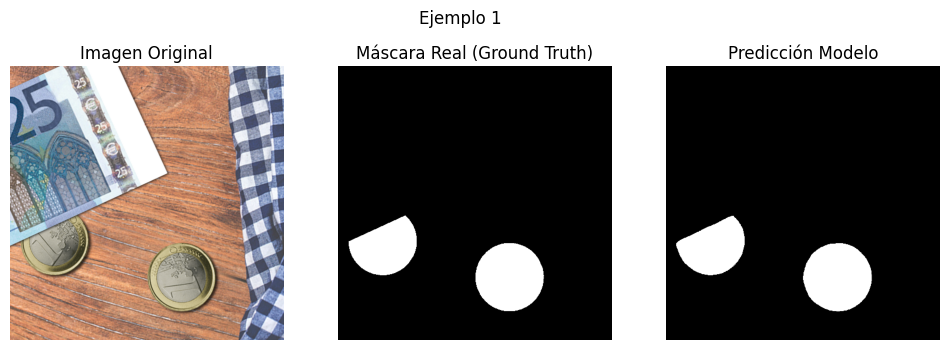

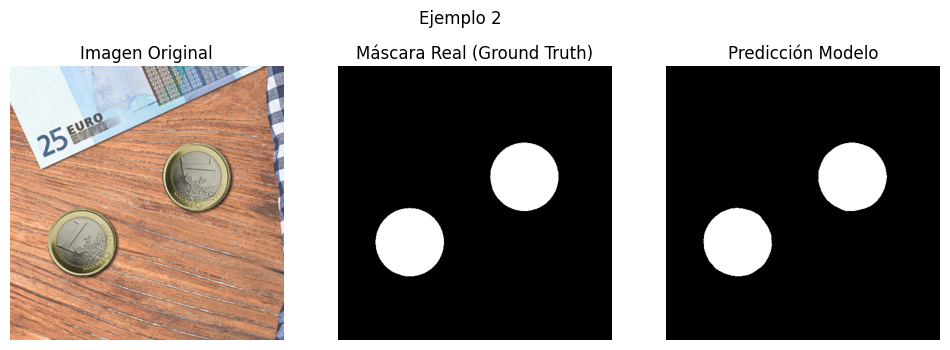

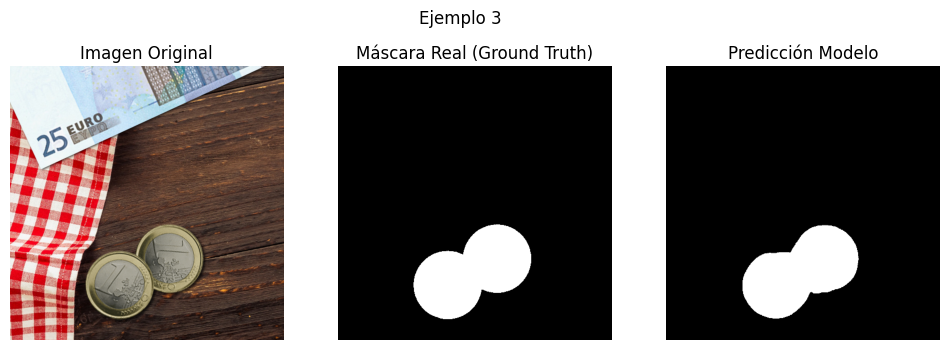

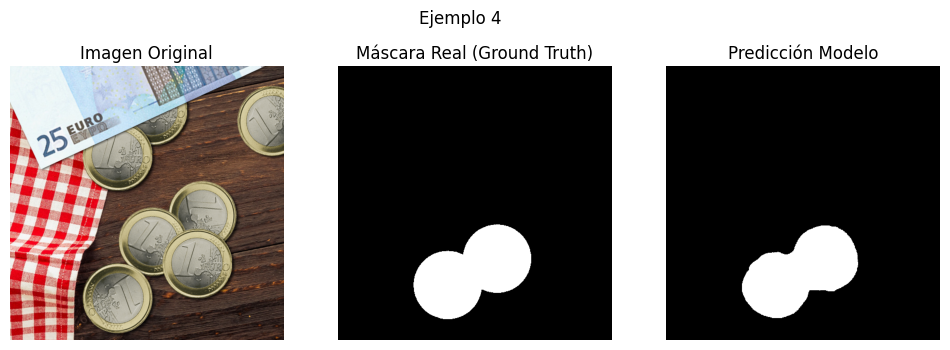

In [19]:
def visualizar_predic(model, dataset_loader, n=4):
    model.eval() # Ponemos el modelo en modo evaluación
    with torch.no_grad():
        images, masks = next(iter(dataset_loader))
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        
        for i in range(n):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            mask = masks[i].cpu().squeeze().numpy()
            pred = outputs[i].cpu().squeeze().numpy()
            
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 3, 1)
            plt.title("Imagen Original")
            plt.imshow(img)
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.title("Máscara Real (Ground Truth)")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Predicción Modelo")
            plt.imshow(pred > 0.5, cmap='gray') 
            plt.axis('off')
            
            plt.suptitle(f'Ejemplo {i+1}')
            plt.show()

visualizar_predic(model, ds_loader)

### Simplificacion 1

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
modelo_simplificado = build_unet(inicio=32, u_skip=[True, True, True, True])
modelo_simplificado = modelo_simplificado.to(device)
train_model(modelo_simplificado, num_epochs=100)

C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Epoch [1/100], Loss: 0.2035
Lote: 0
Epoch [2/100], Loss: 0.1919
Lote: 0
Epoch [3/100], Loss: 0.0824
Lote: 0
Epoch [4/100], Loss: 0.0745
Lote: 0
Epoch [5/100], Loss: 0.0619
Lote: 0
Epoch [6/100], Loss: 0.0517
Lote: 0
Epoch [7/100], Loss: 0.0463
Lote: 0
Epoch [8/100], Loss: 0.0396
Lote: 0
Epoch [9/100], Loss: 0.0633
Lote: 0
Epoch [10/100], Loss: 0.0427
Lote: 0
Epoch [11/100], Loss: 0.0445
Lote: 0
Epoch [12/100], Loss: 0.0387
Lote: 0
Epoch [13/100], Loss: 0.0370
Lote: 0
Epoch [14/100], Loss: 0.0331
Lote: 0
Epoch [15/100], Loss: 0.0409
Lote: 0
Epoch [16/100], Loss: 0.0297
Lote: 0
Epoch [17/100], Loss: 0.0391
Lote: 0
Epoch [18/100], Loss: 0.0365
Lote: 0
Epoch [19/100], Loss: 0.0263
Lote: 0
Epoch [20/100], Loss: 0.0325
Lote: 0
Epoch [21/100], Loss: 0.0271
Lote: 0
Epoch [22/100], Loss: 0.0237
Lote: 0
Epoch [23/100], Loss: 0.0248
Lote: 0
Epoch [24/100], Loss: 0.0211
Lote: 0
Epoch [25/100], Loss: 0.0193
Lote: 0
Epoch [26/100], Loss: 0.0186
Lote: 0
Epoch [27/100], Loss: 0.0171
Lote: 0
Ep

C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


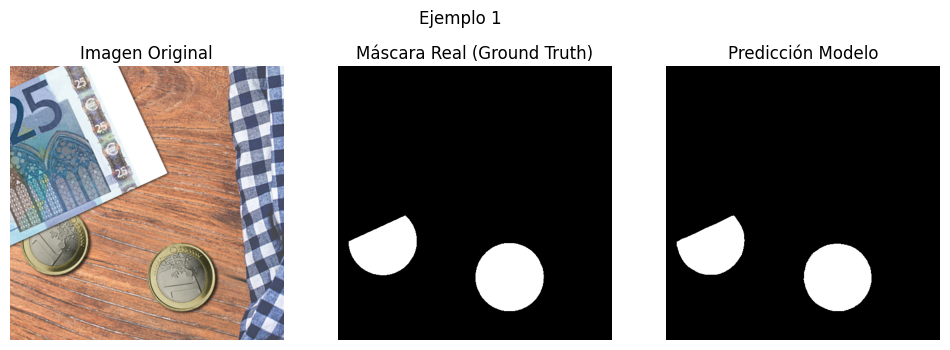

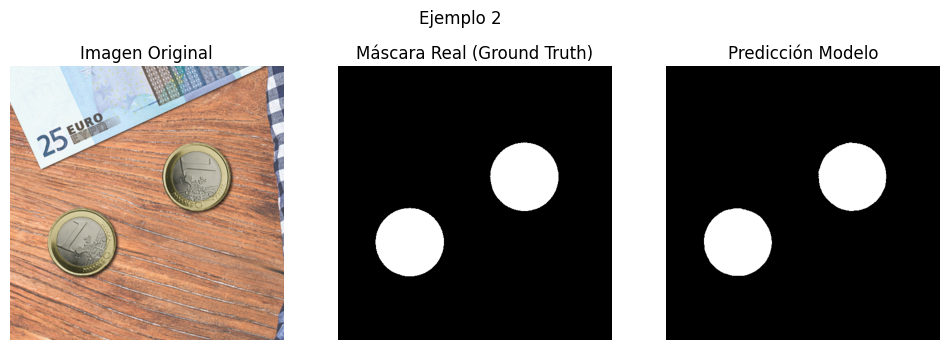

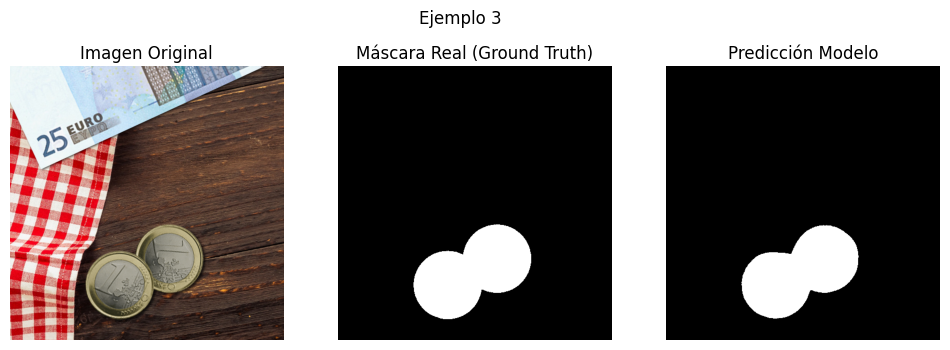

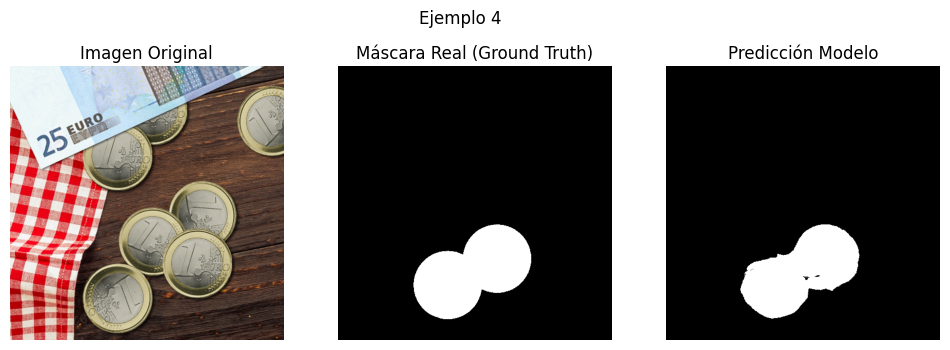

In [22]:
visualizar_predic(modelo_simplificado, ds_loader)

### Simplificacion 2


In [23]:
modelo_simplificado_2 = build_unet(inicio=16, u_skip=[True, True, True, True])
modelo_simplificado_2 = modelo_simplificado_2.to(device)
train_model(modelo_simplificado_2, num_epochs=100)

C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Epoch [1/100], Loss: 0.2351
Lote: 0
Epoch [2/100], Loss: 0.1705
Lote: 0
Epoch [3/100], Loss: 0.1337
Lote: 0
Epoch [4/100], Loss: 0.1083
Lote: 0
Epoch [5/100], Loss: 0.0961
Lote: 0
Epoch [6/100], Loss: 0.0826
Lote: 0
Epoch [7/100], Loss: 0.0765
Lote: 0
Epoch [8/100], Loss: 0.0638
Lote: 0
Epoch [9/100], Loss: 0.0569
Lote: 0
Epoch [10/100], Loss: 0.0462
Lote: 0
Epoch [11/100], Loss: 0.0416
Lote: 0
Epoch [12/100], Loss: 0.0337
Lote: 0
Epoch [13/100], Loss: 0.0296
Lote: 0
Epoch [14/100], Loss: 0.0248
Lote: 0
Epoch [15/100], Loss: 0.0209
Lote: 0
Epoch [16/100], Loss: 0.0192
Lote: 0
Epoch [17/100], Loss: 0.0161
Lote: 0
Epoch [18/100], Loss: 0.0151
Lote: 0
Epoch [19/100], Loss: 0.0136
Lote: 0
Epoch [20/100], Loss: 0.0119
Lote: 0
Epoch [21/100], Loss: 0.0110
Lote: 0
Epoch [22/100], Loss: 0.0100
Lote: 0
Epoch [23/100], Loss: 0.0096
Lote: 0
Epoch [24/100], Loss: 0.0095
Lote: 0
Epoch [25/100], Loss: 0.0088
Lote: 0
Epoch [26/100], Loss: 0.0078
Lote: 0
Epoch [27/100], Loss: 0.0086
Lote: 0
Ep

C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


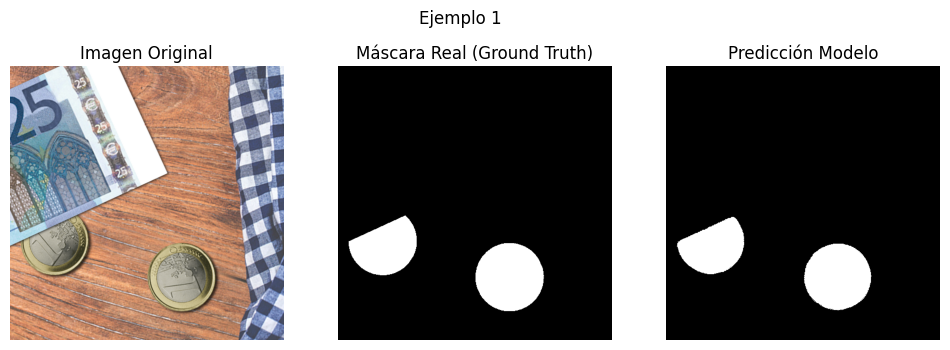

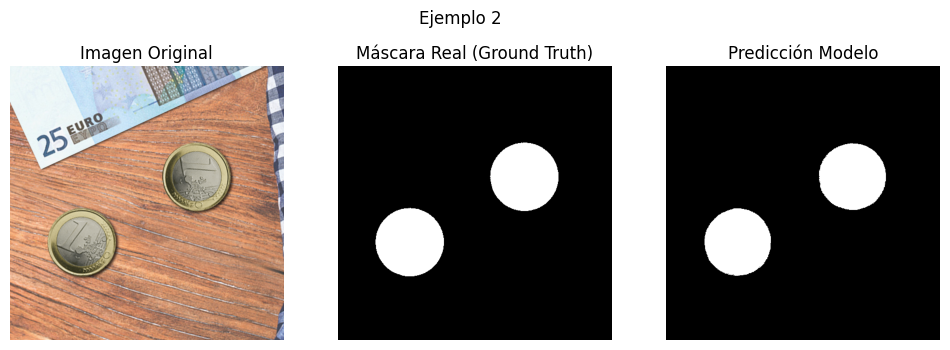

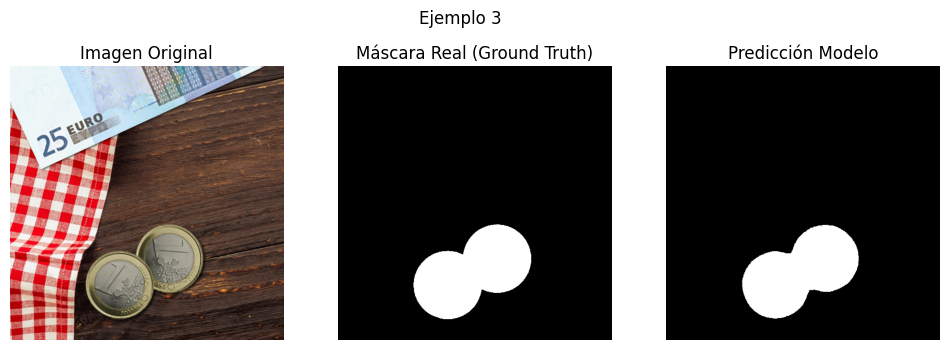

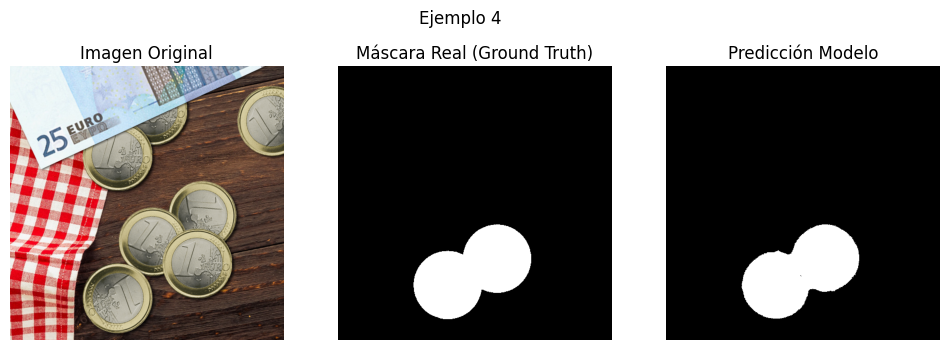

In [24]:
visualizar_predic(modelo_simplificado_2, ds_loader)

### Simplificacion 3


In [25]:
modelo_simplificado_3 = build_unet(inicio=8, u_skip=[True, True, True, True])
modelo_simplificado_3 = modelo_simplificado_3.to(device)
train_model(modelo_simplificado_3, num_epochs=100)

C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Epoch [1/100], Loss: 0.2398
Lote: 0
Epoch [2/100], Loss: 0.1901
Lote: 0
Epoch [3/100], Loss: 0.1597
Lote: 0
Epoch [4/100], Loss: 0.1353
Lote: 0
Epoch [5/100], Loss: 0.1187
Lote: 0
Epoch [6/100], Loss: 0.1072
Lote: 0
Epoch [7/100], Loss: 0.0984
Lote: 0
Epoch [8/100], Loss: 0.0912
Lote: 0
Epoch [9/100], Loss: 0.0856
Lote: 0
Epoch [10/100], Loss: 0.0808
Lote: 0
Epoch [11/100], Loss: 0.0763
Lote: 0
Epoch [12/100], Loss: 0.0725
Lote: 0
Epoch [13/100], Loss: 0.0694
Lote: 0
Epoch [14/100], Loss: 0.0665
Lote: 0
Epoch [15/100], Loss: 0.0641
Lote: 0
Epoch [16/100], Loss: 0.0620
Lote: 0
Epoch [17/100], Loss: 0.0600
Lote: 0
Epoch [18/100], Loss: 0.0579
Lote: 0
Epoch [19/100], Loss: 0.0558
Lote: 0
Epoch [20/100], Loss: 0.0531
Lote: 0
Epoch [21/100], Loss: 0.0497
Lote: 0
Epoch [22/100], Loss: 0.0449
Lote: 0
Epoch [23/100], Loss: 0.0386
Lote: 0
Epoch [24/100], Loss: 0.0499
Lote: 0
Epoch [25/100], Loss: 0.0399
Lote: 0
Epoch [26/100], Loss: 0.0395
Lote: 0
Epoch [27/100], Loss: 0.0320
Lote: 0
Ep

C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\ercil\AppData\Local\Temp\ipykernel_12440\2904514971.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


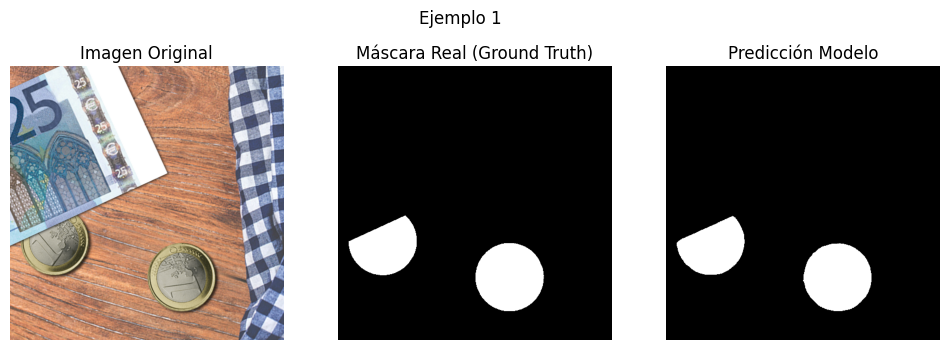

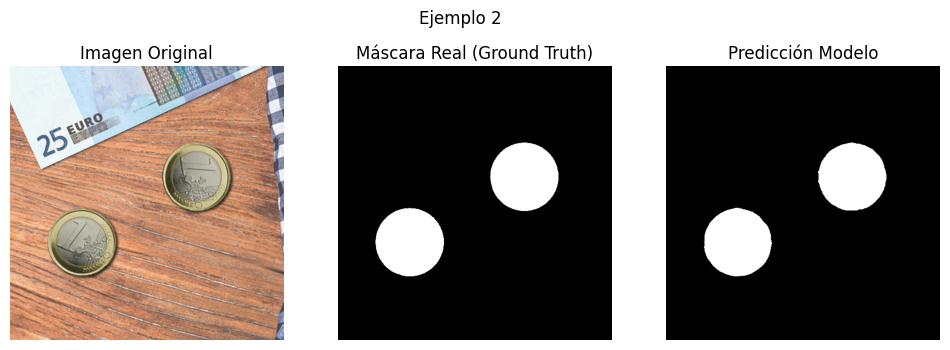

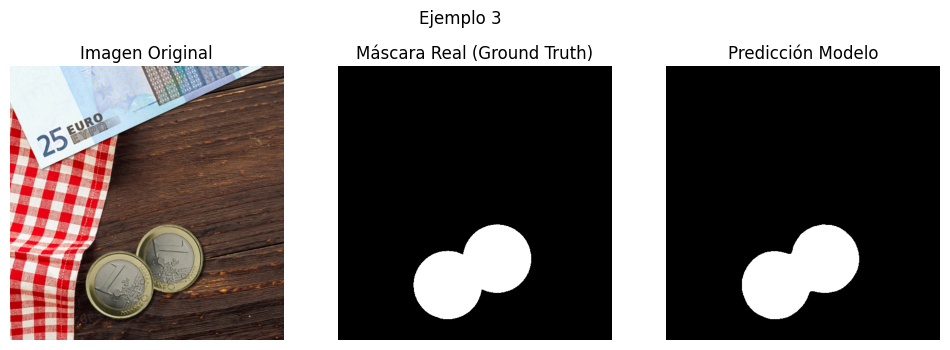

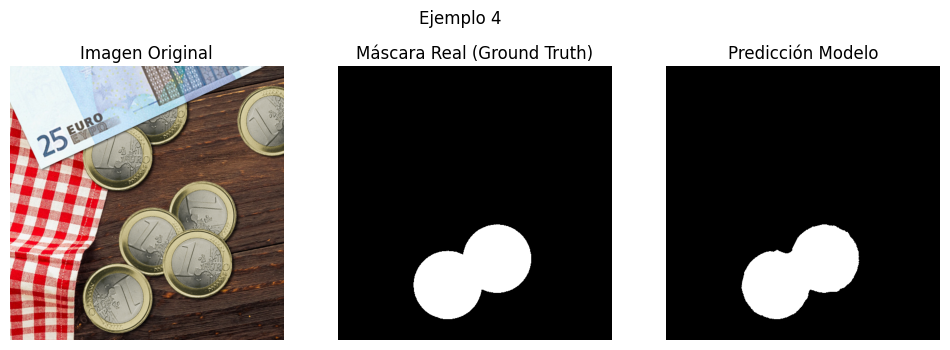

In [26]:
visualizar_predic(modelo_simplificado_3, ds_loader)